In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from src.utils import *


In [39]:
df_DT_TO500RT_SERVER = read_csv_and_convert_date('../artifacts/DT_TO500RT_SERVER/train_data.csv')
df_DT_TO500RT_SERVER.head()

,ds,y,SERVER
0,2022-06-19 12:45:00,0.0,simislnxnss00.si.it
1,2022-06-19 12:45:00,0.0,simislnxnss01.si.it
2,2022-06-19 12:45:00,0.0,simislnxnss02.si.it
3,2022-06-19 12:46:00,0.0,simislnxnss00.si.it
4,2022-06-19 12:46:00,0.0,simislnxnss01.si.it


In [40]:
df_simislnxnss00_si_it = df_DT_TO500RT_SERVER[df_DT_TO500RT_SERVER["SERVER"] == "simislnxnss00.si.it"]
df_simislnxnss00_si_it.tail()

,ds,y,SERVER
4463621,2021-02-12 09:45:00,0.0,simislnxnss00.si.it
4463624,2021-02-12 09:46:00,0.0,simislnxnss00.si.it
4463627,2021-02-12 09:47:00,0.0,simislnxnss00.si.it
4463630,2021-02-12 09:48:00,0.0,simislnxnss00.si.it
4463633,2021-02-12 09:49:00,0.0,simislnxnss00.si.it


In [41]:
df_simislnxnss00_si_it.SERVER[0]

'simislnxnss00.si.it'

In [42]:
# Aggregate 'y' values by date
aggregated_data = df_simislnxnss00_si_it.groupby(df_simislnxnss00_si_it['ds'].dt.date)['y'].sum().reset_index()

aggregated_data.head(5)

,ds,y
0,2021-01-01,60.0
1,2021-01-02,91.0
2,2021-01-03,391.0
3,2021-01-04,382.0
4,2021-01-05,268.0


In [43]:
aggregated_data["ds"] = pd.to_datetime(aggregated_data["ds"])
aggregated_data.dtypes

ds    datetime64[ns]
y            float64
dtype: object

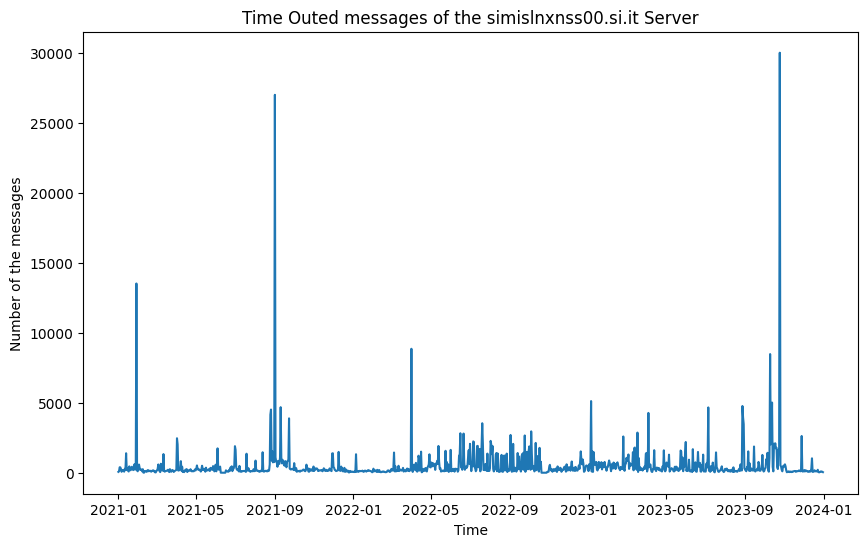

In [44]:
plt.figure(figsize=(10,6))
plt.plot(aggregated_data.ds, aggregated_data.y);
plt.title(f"Time Outed messages of the {df_simislnxnss00_si_it.SERVER[0]} Server")
plt.xlabel('Time');
plt.ylabel('Number of the messages');

<Figure size 2000x1000 with 0 Axes>

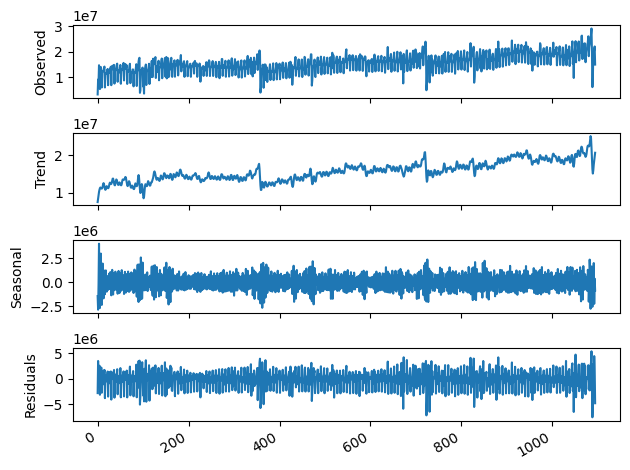

In [27]:
advanced_decomposition = STL(df_DT_NMSG.y, period=4).fit()

plt.figure(figsize=(20,10))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

In [28]:
adf_test = adfuller(df_DT_NMSG.y)

# non-stationary
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -1.5884080397473512
p-value: 0.4894138941325231


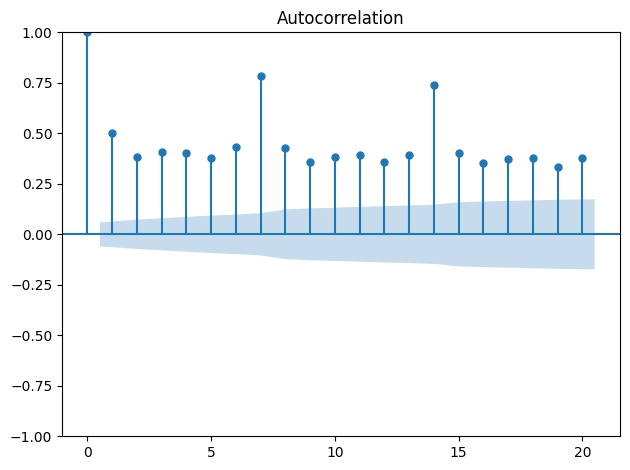

In [29]:
plot_acf(df_DT_NMSG.y, lags=20);

plt.tight_layout()

In [30]:
df_diff = np.diff(df_DT_NMSG.y, n=1)

In [31]:
adf_test = adfuller(df_diff)

# stationary
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -11.1848803349235
p-value: 2.4490646822528157e-20


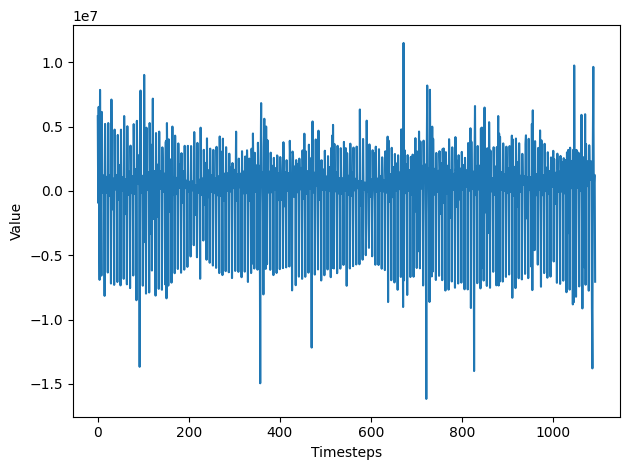

In [32]:
plt.plot(df_diff)
# plt.title('Differenced TOmessages')
plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.tight_layout()

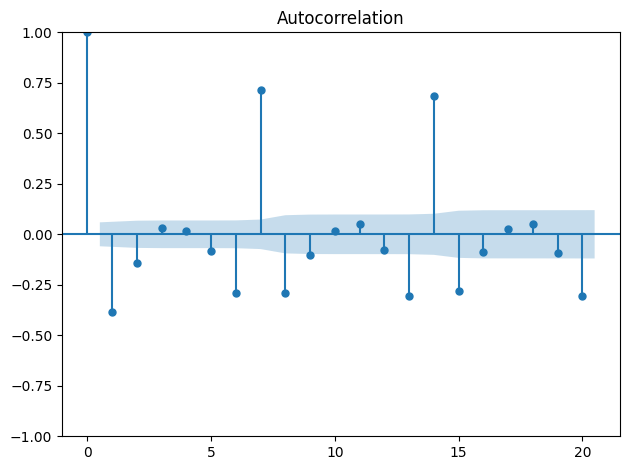

In [33]:
plot_acf(df_diff, lags=20);

plt.tight_layout()

In [34]:
df_ = pd.DataFrame({"y":df_diff})
df_.shape

(1094, 1)

In [35]:
train = df_[:246]
test = df_[246:]

In [36]:
# Forecast with mean

mean = np.mean(train.y)

test.loc[:, "pred_mean"] = mean

# Forecast with last observed value

last_value = train.iloc[-1].y
test.loc[:, "pred_last"] = last_value

/tmp/ipykernel_7875/2899675886.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, "pred_mean"] = mean
/tmp/ipykernel_7875/2899675886.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, "pred_last"] = last_value


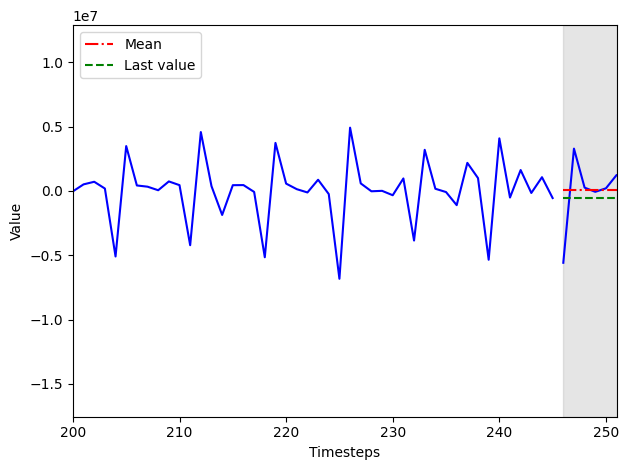

In [37]:

fig, ax = plt.subplots()

ax.plot(train.y, 'b-')
ax.plot(test['y'], 'b-')
ax.plot(test['pred_mean'], 'r-.', label='Mean')
ax.plot(test['pred_last'], 'g--', label='Last value')

ax.axvspan(246, 251, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
plt.xlim(200, 251)

plt.tight_layout()

In [38]:
mse_mean = mean_squared_error(test['y'], test['pred_mean'])
mse_last = mean_squared_error(test['y'], test['pred_last'])

print(mse_mean, mse_last)

12103099812625.371 12406554197093.217
